In [2]:
import os
cwd = os.getcwd()
print(cwd)




c:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman


In [41]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime as dt
import trading_utils_corr as tu

## Fetching prices and defining in and out of samples

In [ ]:


# – universe & dates
universe = [
    'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'META', 'BRK-B', 'LLY', 'V', 'JPM',
    'XOM', 'WMT', 'UNH', 'MA', 'PG', 'JNJ', 'HD', 'COST', 'MRK', 'ABBV', 'CVX',
    'CRM', 'PEP', 'KO', 'ADBE', 'BAC', 'MCD', 'CSCO', 'TMO', 'ACN', 'AVGO',
    'LIN', 'NEE', 'WFC', 'DIS', 'TXN', 'ORCL', 'CMCSA', 'PM', 'RTX', 'HON', 'AMGN',
    'UNP', 'PFE', 'INTC', 'CAT', 'LOW', 'IBM', 'GE', 'GS', 'BA', 'DE', 'NOW',
    'ELV', 'SPGI', 'AXP', 'ISRG', 'AMD', 'BKNG', 'BLK', 'SBUX', 'UPS', 'LMT',
    'PLD', 'C', 'AMT', 'CI', 'GILD', 'TJX', 'PYPL', 'MO', 'T'
]

train_start = '2017-01-01'
train_end   = '2021-12-31'
test_start  = '2022-01-01'
test_end    = dt.date.today().isoformat()

entry_z, exit_z, window = 1.5, 3.5, 20

# – download once
prices = tu.fetch_prices(universe, train_start, test_end)


Fetching 73 tickers: 2017-01-01 → 2025-07-06


[*********************100%***********************]  73 of 73 completed

→ downloaded 73 series across 2137 rows


In [55]:
window = 30

## Selecting cointegrated pairs

In [28]:
#  – find top correlated return-pairs on the *training* slice
corr_pairs = tu.top_correlated_pairs(
    prices.loc[train_start:train_end],
    top_n=400, min_corr=0.6)

#  – ADF filter & hedge ratios
stationary_df = tu.select_stationary_pairs(
    corr_pairs,
    prices.loc[train_start:train_end],
    adf_p=0.05)

ADF filtering: 264it [00:19, 13.80it/s]


## Applying the static hedge ratio trading strategy 

Backtesting (static): 100%|██████████| 38/38 [00:03<00:00, 11.40it/s]
c:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils_corr.py:366: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = pnl_df["Total"].resample("M").sum()


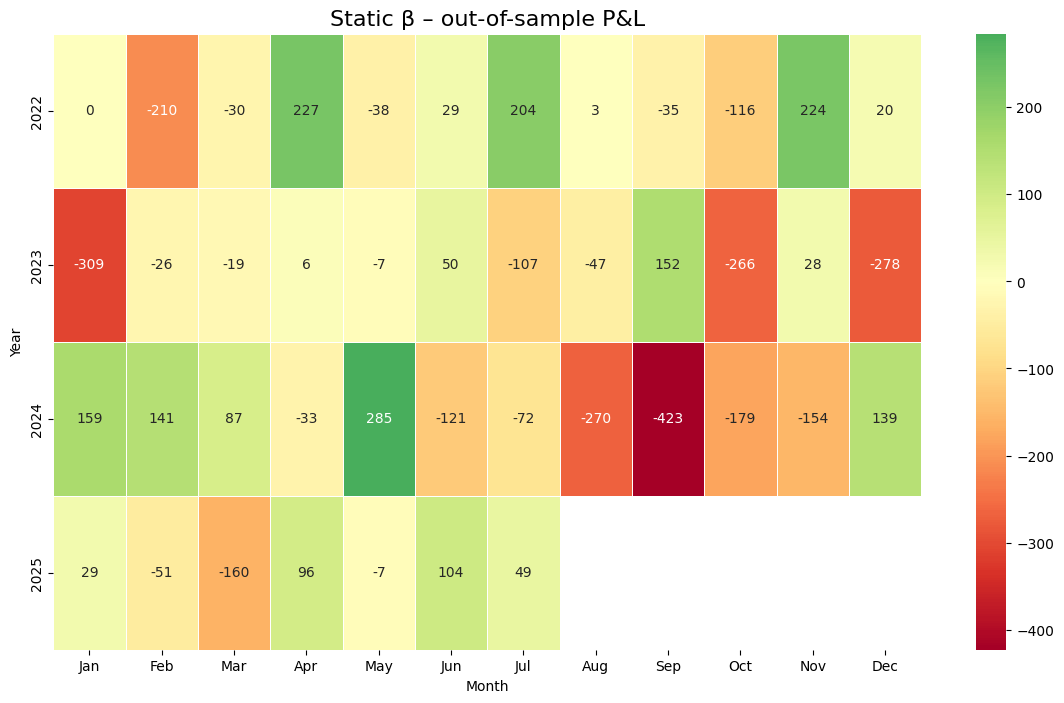

,Total P&L,Volatility,Sharpe,Max Drawdown
Pair,,,,
ACN-HD,203.681183,3.122934,1.179217,-54.222891
ADBE-NOW,123.212432,7.647628,0.291295,-143.559982
ADBE-META,112.234809,10.704028,0.189577,-357.731025
MSFT-SPGI,108.037082,2.703589,0.722500,-61.742244
ISRG-MSFT,96.392115,4.084988,0.426635,-72.554771
AXP-JPM,77.741100,1.609644,0.873226,-28.033787
MA-V,61.378277,1.770294,0.626866,-35.621132
HD-MSFT,52.402846,2.723419,0.347893,-70.928501
CRM-MA,42.586158,2.445271,0.314882,-59.471707


In [56]:

#  – out-of-sample back-test
pnl_df = tu.backtest_static_pairs(
    stationary_df,
    prices,
    test_start, test_end,
    entry_z=entry_z, exit_z=exit_z, window=window)

#  – quick diagnostics
tu.plot_pnl_heatmap(pnl_df, title='Static β – out-of-sample P&L')
perf = tu.analyze_performance(pnl_df)
display(perf.head(10))


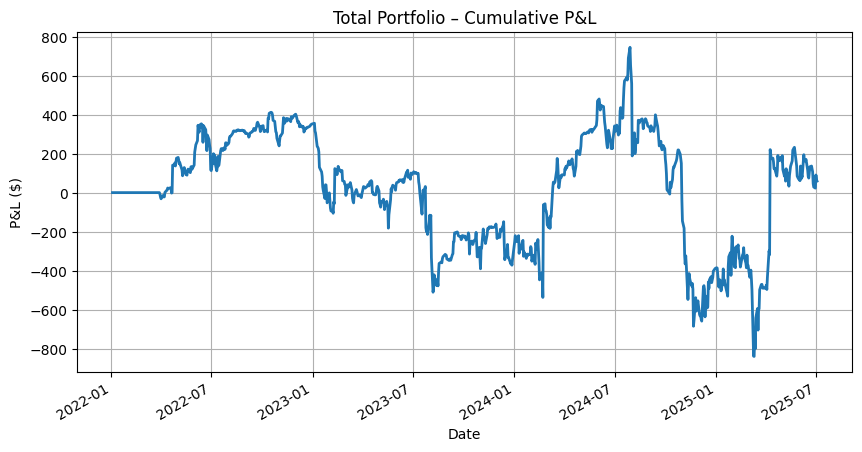

In [30]:
# – portfolio equity curve
import matplotlib.pyplot as plt

equity_curve = pnl_df['Total'].cumsum()
plt.figure(figsize=(10, 5))
equity_curve.plot(lw=2)
plt.title('Total Portfolio – Cumulative P&L')
plt.xlabel('Date')
plt.ylabel('P&L ($)')
plt.grid(True)
plt.show()


## Dynamic hedge ratio estimation via Kalman filter

Backtesting (dynamic):   0%|          | 0/38 [00:00<?, ?it/s]

Backtesting (dynamic): 100%|██████████| 38/38 [00:04<00:00,  7.75it/s]
c:\Users\user\Desktop\math_finance\Stat_arb_pair_kalman\trading_utils_corr.py:366: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = pnl_df["Total"].resample("M").sum()


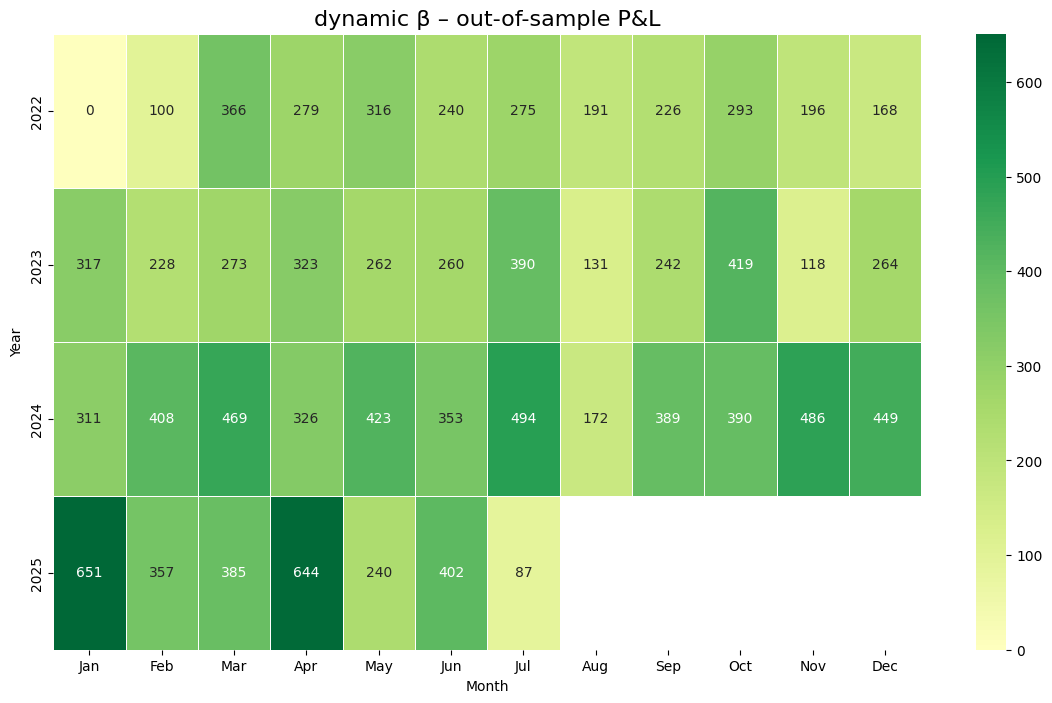

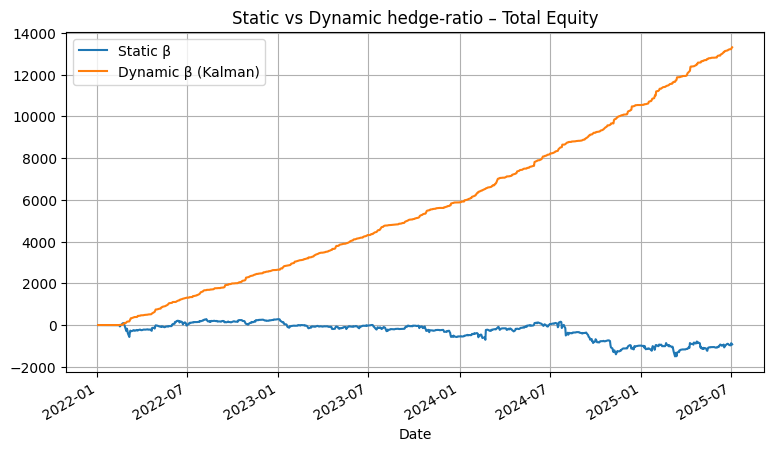

In [61]:
# dynamic β back-test
kalman_kwargs = dict(delta=1e-2, obs_var=1.0)   
pnl_dyn = tu.backtest_dynamic_pairs(
    selected_pairs_df=stationary_df,
    price_df=prices,
    test_start=test_start,
    test_end=test_end,
    entry_z=entry_z, exit_z=exit_z, window=window,
    kalman_kwargs=kalman_kwargs,
)
# plot heatmap
tu.plot_pnl_heatmap(pnl_dyn, title='dynamic β – out-of-sample P&L')

# Plot equity curves
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5))
(pnl_df['Total'].cumsum()).plot(label='Static β')
(pnl_dyn['Total'].cumsum()).plot(label='Dynamic β (Kalman)')
plt.title('Static vs Dynamic hedge-ratio – Total Equity')
plt.legend()
plt.grid(True)
plt.show()


## Comparison of the Hedge ratio estimation

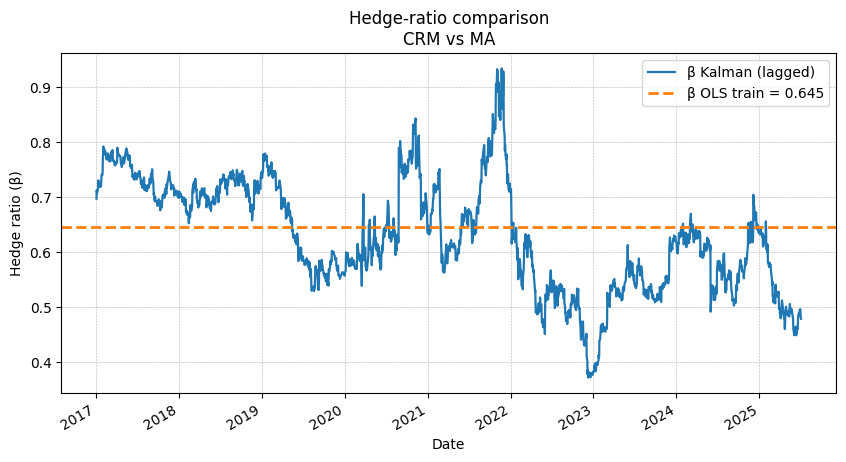

In [62]:
# – Kalman vs OLS hedge ratio
import matplotlib.pyplot as plt
import numpy as np

# 1) Pull price series
y_full = prices[a1]
x_full = prices[a2]

# 2) STATIC β via OLS on the *training* slice
y_train = y_full.loc[train_start:train_end]
x_train = x_full.loc[train_start:train_end]
slope, intercept = np.polyfit(x_train, y_train, 1)    # with intercept
beta_static = slope   # β_OLS

# 3) DYNAMIC β via Kalman (posterior lagged by 1 bar)
ba_df      = tu.kalman_beta_alpha(y_full, x_full, **kalman_kwargs)
beta_kal   = ba_df["beta"].shift(1)                    # β_{t|t-1}

# 4) Plot
plt.figure(figsize=(10, 5))
beta_kal.plot(label="β Kalman (lagged)", lw=1.6)
plt.axhline(beta_static, color="tab:orange", ls="--", lw=2,
            label=f"β OLS train = {beta_static:.3f}")
plt.title(f"Hedge-ratio comparison\n{a1} vs {a2}")
plt.ylabel("Hedge ratio (β)")
plt.legend()
plt.grid(True, ls="--", lw=0.4)
plt.show()


## Budget constrained portfolio

Dynamic β (budgeted): 100%|██████████| 38/38 [00:05<00:00,  6.77it/s]


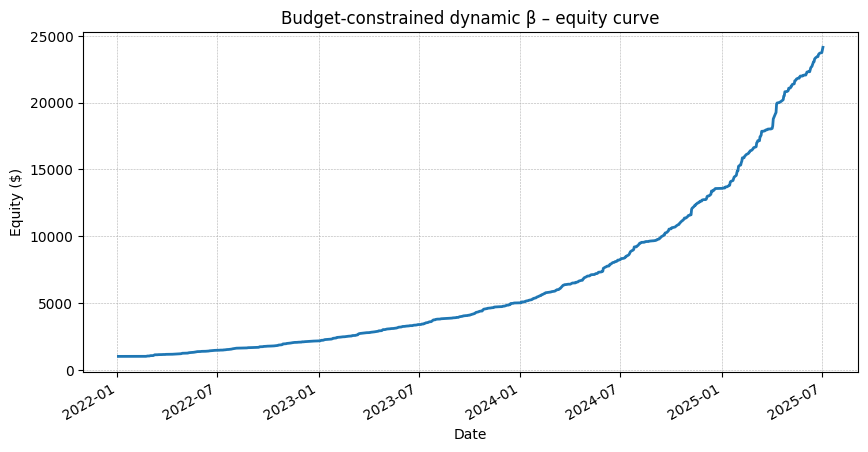

In [63]:

# 1) Portfolio budget settings 
budget       = 1000       # total $ 
max_pairs    = 10                 # worst-case number of pairs you expect
per_pair_cap = budget / max_pairs # clip for EACH pair's gross notional

#  2) Loop over pairs and build P&L
price_test = prices.loc[test_start:test_end]
pnl_cap    = pd.DataFrame(index=price_test.index)

for _, row in tqdm(stationary_df.iterrows(),
                   total=len(stationary_df),
                   desc="Dynamic β (budgeted)"):

    a1, a2 = row["pair"]
    if a1 not in price_test.columns or a2 not in price_test.columns:
        continue

    y, x = price_test[a1], price_test[a2]

    # Kalman β/α (posterior) and one bar lag for prior use (random walk model so predicted = prior)
    ba_df   = tu.kalman_beta_alpha(y, x, **kalman_kwargs)
    beta_l  = ba_df["beta"].shift(1)
    alpha_l = ba_df["alpha"].shift(1)

    # Normalised spread  s*_t = (y − βx − α)/(1+β)
    denom   = (1.0 + beta_l).replace(0, np.nan)
    spread  = (y - beta_l * x - alpha_l) / denom

    # Generate trading signals (±1, 0)
    sig     = tu.generate_trading_signals(
                 spread, entry_z=entry_z, exit_z=exit_z, window=window
              )

    #  Budget clip
    # Tomorrow's gross $ notional if we traded 1 share long and β shares short
    gross_raw = (abs(y.shift(-1)) + abs(beta_l.shift(-1) * x.shift(-1))).fillna(0)

    # Scale factor so gross ≤ per_pair_cap  (never lever UP, only clip DOWN)
    scale     = (per_pair_cap / gross_raw).clip(upper=1.0).fillna(0.0)

    # Apply scale to the position signal
    pos_scaled = sig["position"] * scale

    # Daily P&L 
    daily_pnl  = pos_scaled.shift(1) * spread.diff()   # enter next bar
    pnl_cap[f"{a1}-{a2}"] = daily_pnl

#  3) Aggregate & plot
pnl_cap = pnl_cap.fillna(0.0)
pnl_cap["Total"] = pnl_cap.sum(axis=1)

capital_base = budget           
equity_curve = (1 + pnl_cap["Total"] / capital_base).cumprod() * capital_base

plt.figure(figsize=(10, 5))
equity_curve.plot(lw=2)
plt.title("Budget-constrained dynamic β – equity curve")
plt.ylabel("Equity ($)")
plt.grid(True, ls="--", lw=0.4)
plt.show()
